# Exploratory analysis of members of the IBOV index

In this sample notebook you will find possible company insights in the Ibovespa Brasil Sao Paulo Stock Exchange (IBOV) after market. The IBOV Index is a gross total return index weighted by free float market cap & is comprised of the most liquid stocks traded on the Sao Paulo Stock Exchange.

By the end of this exercise you should be able to use the Bloomberg Query Language (BQL) to retrieve and transform financial data directly in the Bloomberg Cloud and make simple data analysis and visualization using Python. Optionally you might even be able to find investment opportunities.

There are a couple of assumptions:

- First, the universe is the all the members of the IBOV Index;
- To find insights you will use tresholds for different market data, and see which companies hit those tresholds;
- You will only consider companies that hit at least three of these thresholds.

The data fields you will handle in this exercise are:

- Trading volume
- Last price
- Relative strength index (RSI)
- 30-day volatility and maximum 30-day volatility
- 90-day volatility and maximum 90-day volatility

Your end results will be a `pandas` data frame with the companies that hit the thresholds and some insights about their behaviour in the past.

## Load a single data point

This is a simple recipe to get one data point for a single ticker:

1. Import required Python library: BQL
2. Instantiate the interface to the BQL service
3. Define the security or securities you want to retreive data from
4. Define the field or fields  to retrieve
5. Generate the BQL request
6. Execute the request
7. Get the response

The following cells of code illustrate this simple recipe retrieving the last price for one single security (ticker) and show the result on screen.

In [1]:
# Import BQL library
import bql

In [2]:
# Instantiate an object to interface with the BQL service
bq = bql.Service()

In [3]:
# Define a variable for the security 
ticker = "VVAR3 BZ Equity"

# Define a data item for the last price (`PX_LAST`)
last_price = bq.data.px_last()

# Generate the request using the sercurity variable and data item
request =  bql.Request(ticker, last_price)

# Execute the request
response = bq.execute(request)

# Display the response in a DataFrame
df = response[0].df()
df

,DATE,CURRENCY,PX_LAST()
ID,,,
VVAR3 BZ Equity,2020-02-21,BRL,16.309999


## Trading volume

Now it's your time to write code.

The first field that you will explore is the total number of shares traded of all members of the IBOV Index. You will compare the yesterday's traded volume with the latest 3-month average traded volume.

#### 1. Import required Python library: BQL

In [4]:
import bql

#### 2. Instantiate the interface to the BQL service

In [5]:
bq = bql.Service()

#### 3. Define the security or securities you want to retreive data from: members of the IBOV Index.

In [6]:
# List of securities to retrieve
tickers = bq.univ.members("IBOV Index")

#### 4. Define the field or fields to retrieve

You will retrieve the total number of shares trated yesterday using `bq.data.px_volume`. Note that there are arguments to pass to indicate yesterday's data.

BQL allows you to apply functions to fields. You will calculate 3-month average trading volume using `bq.func.avg`. Use `bq.func.range` to define the dates range used when calculating the average volume.

In [7]:
# Define fields to retrieve
volume = bq.data.px_volume(dates="-1D", fill="PREV")
volume_avg_3m = bq.func.avg(bq.data.px_volume(start="-3M", end='-1D'))

#### 5. Generate the BQL request

In [8]:
# Generate the request
request = bql.Request(
    tickers,
    {'PX_VOLUME': volume, 'PX_VOLUME_AVG_3M': volume_avg_3m, "PX_VOLUME_RATIO": volume / volume_avg_3m}
)

#### 6. Execute the request

In [9]:
# Execute the request
response = bq.execute(request)

#### 7. Get the response

In [10]:
# Combine response
df_volume = bql.combined_df(response)

In [11]:
# Let's see the first elements in the data frame
df_volume.head()

,DATE,PX_VOLUME_RATIO,PX_VOLUME_AVG_3M,PX_VOLUME
ID,,,,
ENBR3 BS Equity,2020-02-20,0.775194,2.989445e+06,2317400.0
HGTX3 BS Equity,2020-02-20,1.093243,2.469076e+06,2699300.0
RADL3 BS Equity,2020-02-20,1.460945,1.175061e+06,1716700.0
BBAS3 BS Equity,2020-02-20,1.016880,1.185213e+07,12052200.0
IGTA3 BS Equity,2020-02-20,0.779776,1.419382e+06,1106800.0


### Simple plotting

Python has a vast set of tools to make sofisticated data visualization. One of these tools is `matplotlib` which emerged to mimic MATLAB's plotting capabilities in Python. `pandas` uses `matplotlib` for plotting.

You can import `matplotlib`'s pyplot module and use its style sheets as follows:

In [14]:
import pandas

%matplotlib inline
from matplotlib import pyplot

# Use predefined styles to plots: colors, font size, ...
pyplot.style.use(['seaborn', 'seaborn-poster', 'seaborn-ticks'])

Plot the histogram of the ratio between volume and average volume. `pandas` data frames have the `plot` method which can be used to draw line plots, scatter plots, histograms, etc.

Use `df_volume['column'].plot.hist()` to plot your histogram.

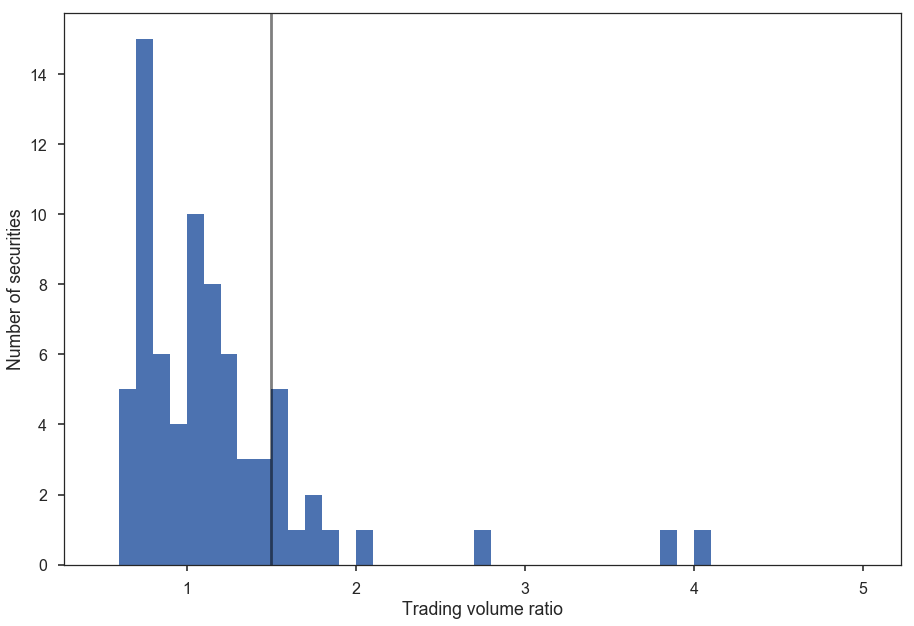

In [15]:
# Plot the histogram
ax = df_volume['PX_VOLUME_RATIO'].plot.hist(bins=pandas.np.arange(0.5, 5.1, 0.1))

# It's nice to have labels on the axis and optimize the use of the figure space
ax.axvline(1.5, color='k', linestyle='-', alpha=0.5)
ax.set_xlabel('Trading volume ratio')
ax.set_ylabel('Number of securities')
ax.figure.tight_layout()

Identify securities that are being traded with more than 150% of their average volume. Call them `outliers`. 

* Suggestion 1: use `df_volume.query`.
* Suggestion 2: sort your outliers using the method `df_volume.sort_values(by='PX_VOLUME_RATIO')`.

In [16]:
outliers = df_volume.query('PX_VOLUME_RATIO > 1.5').sort_values(by='PX_VOLUME_RATIO')
outliers

,DATE,PX_VOLUME_RATIO,PX_VOLUME_AVG_3M,PX_VOLUME
ID,,,,
TOTS3 BS Equity,2020-02-20,1.509045,2.011006e+06,3034700.0
BPAC11 BS Equity,2020-02-20,1.516661,2.182031e+06,3309400.0
EGIE3 BS Equity,2020-02-20,1.551206,1.378992e+06,2139100.0
GOAU4 BS Equity,2020-02-20,1.563400,1.194537e+07,18675400.0
PETR4 BS Equity,2020-02-20,1.597394,4.602677e+07,73522900.0
ECOR3 BS Equity,2020-02-20,1.638804,3.234189e+06,5300200.0
EMBR3 BS Equity,2020-02-20,1.771688,2.626140e+06,4652700.0
TAEE11 BS Equity,2020-02-20,1.772716,1.707042e+06,3026100.0
ITUB4 BS Equity,2020-02-20,1.825793,2.629471e+07,48008700.0


### Explore the timeseries of a selected security

Select the security with the highest volume-to-average ratio and load the time-series for the last year of last price (`PX_LAST`), trading volume (`PX_VOLUME`) and price change.

In [17]:
# Define a variable for the security 
ticker = outliers.iloc[-1].name

# Define a data item for the last price, volume and price change
last_price = bq.data.px_last()
volume = bq.data.px_volume()
last_price_change = bq.func.pct_diff(bq.data.px_last())

# Generate the request using the sercurity variable and data item
request =  bql.Request(
    ticker,
    {'PX_LAST': last_price, 'PX_VOLUME': volume, 'PX_LAST_PCT_DIFF': last_price_change},
    with_params={'dates': bq.func.range('-1Y', '0D')}
)

# Execute the request
response = bq.execute(request)

In [18]:
# Get data frame for each field
df_price = response.get('PX_LAST').df()
df_volume = response.get('PX_VOLUME').df()
df_price_change = response.get('PX_LAST_PCT_DIFF').df()

Show the first rows in the price and volume data frames. Can you notice differences and any weird values?

In [19]:
df_price.head()

,DATE,CURRENCY,PX_LAST
ID,,,
PCAR4 BS Equity,2019-02-21,BRL,96.00
PCAR4 BS Equity,2019-02-22,BRL,95.33
PCAR4 BS Equity,2019-02-23,BRL,NaN
PCAR4 BS Equity,2019-02-24,BRL,NaN
PCAR4 BS Equity,2019-02-25,BRL,95.84


In [20]:
df_volume.head()

,DATE,PX_VOLUME
ID,,
PCAR4 BS Equity,2019-02-21,1762900.0
PCAR4 BS Equity,2019-02-22,1249200.0
PCAR4 BS Equity,2019-02-23,NaN
PCAR4 BS Equity,2019-02-24,NaN
PCAR4 BS Equity,2019-02-25,1054700.0


Notice that both data frames have different columns and that some rows have `NaN` values. `NaN` stands for not-a-number, which we can interpret as missing data. `pandas` data frames have a method called `.dropna()`, which removes rows that contain missing data. The indices of the data frames above are the securty names, for plotting time-series it's better to have the dates as the indices. We can change the index using the `.set_index()` method.

In [21]:
df_price = response[0].df()\
    .dropna()\
    .set_index('DATE')
df_volume = response[1].df()\
    .dropna()\
    .set_index('DATE')
df_price_change = response[2].df()\
    .dropna()\
    .set_index('DATE')

See the difference?

In [22]:
df_price.head(10)

,CURRENCY,PX_LAST
DATE,,
2019-02-21,BRL,96.00
2019-02-22,BRL,95.33
2019-02-25,BRL,95.84
2019-02-26,BRL,94.80
2019-02-27,BRL,94.08
2019-02-28,BRL,93.11
2019-03-01,BRL,93.45
2019-03-06,BRL,91.89
2019-03-07,BRL,90.78


In [23]:
df_volume.head(10)

,PX_VOLUME
DATE,
2019-02-21,1762900.0
2019-02-22,1249200.0
2019-02-25,1054700.0
2019-02-26,1021100.0
2019-02-27,968800.0
2019-02-28,1261400.0
2019-03-01,1047100.0
2019-03-06,763500.0
2019-03-07,902500.0


In [24]:
df_price_change.head(10)

,PX_LAST_PCT_DIFF
DATE,
2019-02-22,-0.697917
2019-02-25,0.534984
2019-02-26,-1.085142
2019-02-27,-0.759494
2019-02-28,-1.031037
2019-03-01,0.365159
2019-03-06,-1.669342
2019-03-07,-1.207966
2019-03-08,1.674378


Create a graph of the time-series of last price, price change and trading volume as line plots.

You can use `pyplot.subplots` to create sub plots. Tip: use the argument `sharex=True` so that all subplots share the x-axis.

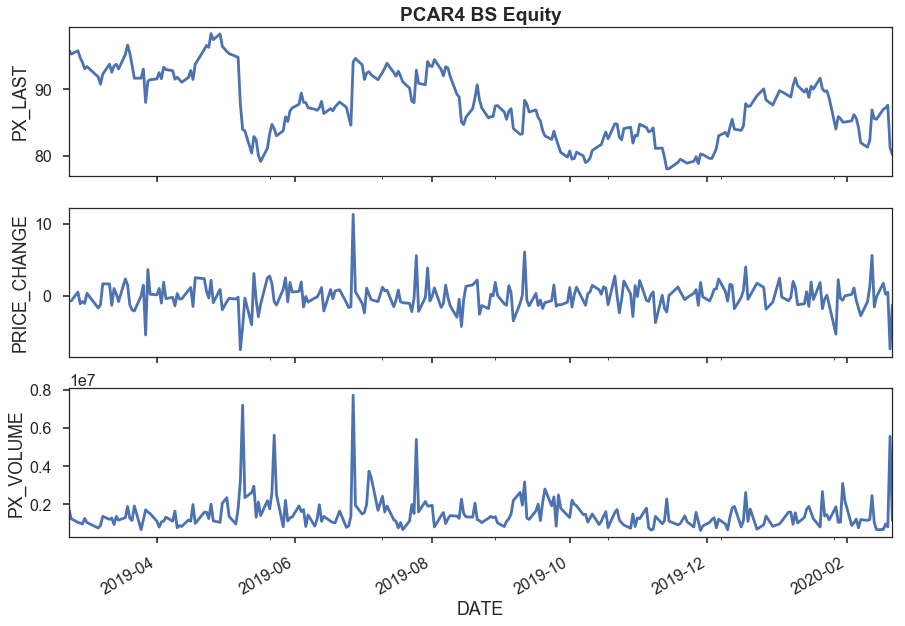

In [25]:
# Create figure and subplots axes
fig, axs = pyplot.subplots(nrows=3, ncols=1, sharex=True)

# Plot time-series
df_price.plot.line(ax=axs[0], legend=False)
df_price_change.plot.line(ax=axs[1], legend=False)
df_volume.plot.line(ax=axs[2], legend=False)

# Makeup: title, axis labels and layout
axs[0].set_title(ticker, weight='bold')
axs[0].set_ylabel('PX_LAST')
axs[1].set_ylabel('PRICE_CHANGE')
axs[2].set_ylabel('PX_VOLUME')
fig.tight_layout()

## Relative strength index

The relative strength index (RSI) is a non-trending indicator that measures the momentum of a security to determine whether it is in an overbought or oversold condition. The RSI has values between 0 and 100. Traditional interpretation and usage of RSI are that values above or equal 70 indicate that a security is becoming overbought or overvalued and may be primed for a trend reversal in price. An RSI less or equal 30 indicates an oversold or undervalued condition.

In this section you will:

1. Request the RSI of the members of the IBOV Index;
2. Plot the RSI histogram. Set the bins of the histogram from 0 to 100 with spacing of 5;
3. Filter securities that have RSI above the 69 threshold;
4. Filter securities that have RSI belo the 31 threshold;
5. *Optional*: Load and plot last price and RSI of filtered securities for the past year;

In [26]:
# Request RSI for all IBOV Index members
tickers = bq.univ.members("IBOV Index")
rsi = bq.data.rsi(dates="-1D", fill="PREV")
request =  bql.Request(
    tickers,
    {'RSI': rsi}
)
response = bq.execute(request)
df_rsi = response[0].df()

In [27]:
df_rsi.sample(10)

,DATE,RSI
ID,,
EMBR3 BS Equity,2020-02-20,61.853564
BRKM5 BS Equity,2020-02-20,45.979442
WEGE3 BS Equity,2020-02-20,69.158489
PCAR4 BS Equity,2020-02-20,38.188355
MRVE3 BS Equity,2020-02-20,47.812329
RAIL3 BS Equity,2020-02-20,52.034793
LAME4 BS Equity,2020-02-20,46.832932
YDUQ3 BS Equity,2020-02-20,61.983876
RADL3 BS Equity,2020-02-20,47.831697


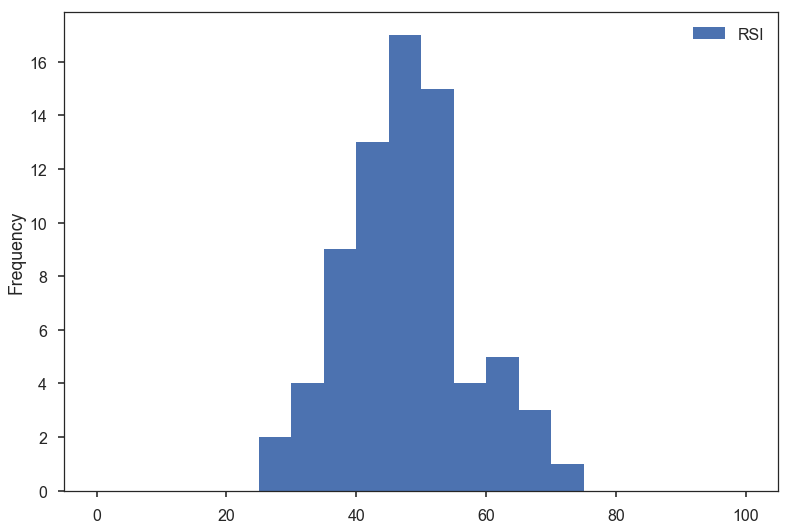

In [28]:
# Plot RSI histogram with bins from 0 to 100 with spacing of 5
df_rsi.plot.hist(bins=pandas.np.arange(0, 105, 5))

In [29]:
# Filter securities that have RSI above the 69 threshold;
df_rsi.query('RSI > 69')

,DATE,RSI
ID,,
MRFG3 BS Equity,2020-02-20,71.219438
WEGE3 BS Equity,2020-02-20,69.158489


In [30]:
# Filter securities that have RSI belo the 31 threshold;
df_rsi.query('RSI < 31')

,DATE,RSI
ID,,
ABEV3 BS Equity,2020-02-20,28.484103
CVCB3 BS Equity,2020-02-20,27.842162


In [31]:
# Load last price and RSI of filtered securities
tickers = ['MRFG3 BS Equity', 'ABEV3 BS Equity', 'CVCB3 BS Equity']

# Define a data item for the last price and RSI
last_price = bq.data.px_last()
rsi = bq.data.rsi()

# Generate the request using the sercurity variable and data item
request =  bql.Request(
    tickers,
    {'PX_LAST': last_price, 'RSI': rsi},
    with_params={'dates': bq.func.range('-1Y', '0D')}
)

# Execute the request
response = bq.execute(request)

# Display the response in a DataFrame
df_price = response.get("PX_LAST").df()
df_rsi = response.get("RSI").df()

In [32]:
df_price.head()

,DATE,CURRENCY,PX_LAST
ID,,,
MRFG3 BS Equity,2019-02-21,BRL,5.58
MRFG3 BS Equity,2019-02-22,BRL,5.48
MRFG3 BS Equity,2019-02-23,BRL,NaN
MRFG3 BS Equity,2019-02-24,BRL,NaN
MRFG3 BS Equity,2019-02-25,BRL,5.49


In [33]:
df_rsi.head()

,DATE,RSI
ID,,
MRFG3 BS Equity,2019-02-21,42.671650
MRFG3 BS Equity,2019-02-22,40.240179
MRFG3 BS Equity,2019-02-23,NaN
MRFG3 BS Equity,2019-02-24,NaN
MRFG3 BS Equity,2019-02-25,40.604653


Do some magic to rearrange the data in the data frames:

In [34]:
df_price = df_price.dropna()\
    .reset_index()\
    .pivot(index='DATE', columns='ID', values='PX_LAST')
df_rsi = df_rsi.dropna()\
    .reset_index()\
    .pivot(index='DATE', columns='ID', values='RSI')

In [35]:
df_price.head()

ID,ABEV3 BS Equity,CVCB3 BS Equity,MRFG3 BS Equity
DATE,,,
2019-02-21,18.32,61.89,5.58
2019-02-22,18.32,60.80,5.48
2019-02-25,18.39,60.40,5.49
2019-02-26,18.49,59.97,5.45
2019-02-27,18.36,59.26,5.38


In [36]:
df_rsi.head()

ID,ABEV3 BS Equity,CVCB3 BS Equity,MRFG3 BS Equity
DATE,,,
2019-02-21,54.907059,51.133224,42.671650
2019-02-22,54.907059,46.079826,40.240179
2019-02-25,55.857928,44.347738,40.604653
2019-02-26,57.244959,42.498365,39.565175
2019-02-27,54.832822,39.564543,37.744166


Plot time-series of last price and RSI

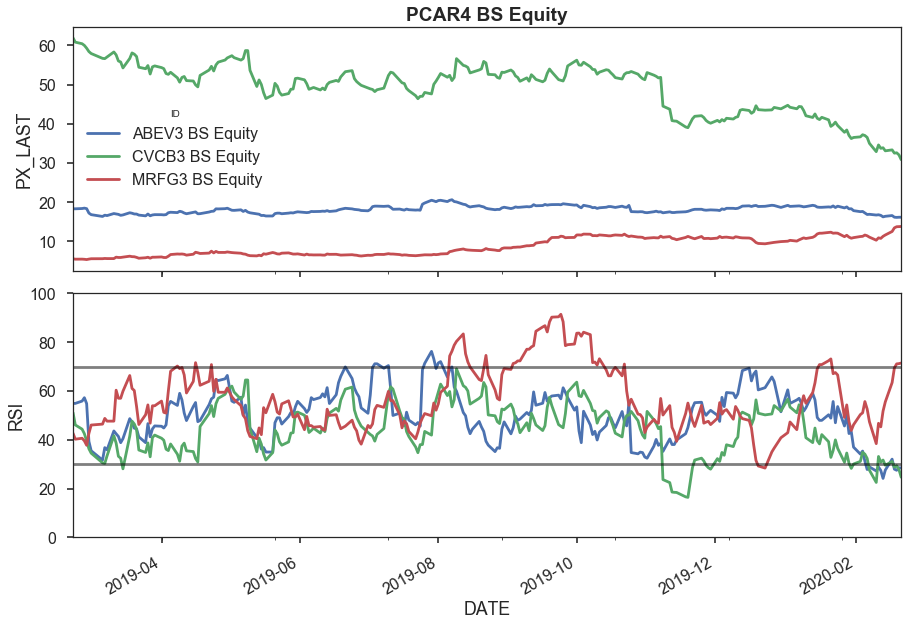

In [37]:
# Create figure and subplots axes
fig, axs = pyplot.subplots(nrows=2, ncols=1, sharex=True)

# Plot time-series
df_price.plot.line(ax=axs[0])
df_rsi.plot.line(ax=axs[1], legend=False)

# Makeup: title, axis labels and layout
axs[1].axhline(30, color='k', linestyle='-', alpha=0.5)
axs[1].axhline(70, color='k', linestyle='-', alpha=0.5)
axs[1].set_ylim(0, 100)
axs[0].set_title(ticker, weight='bold')
axs[0].set_ylabel('PX_LAST')
axs[1].set_ylabel('RSI')
fig.tight_layout()

## Volatility

Volatility measures the variation of trading prices over a certain time-frame. It is usually measured by the standard deviation of logarithmic returns. In this part you will retrieve the 30-day and 90-day volatility of the members of the IBOV Index and compare to it's highest 30-day and 90-day volatilities since one year ago.

To retrieve the volatility in BQL you have to set the `calc_interval` parameter to define the time-frame.

In [38]:
# List of securities to retrieve
tickers = bq.univ.members("IBOV Index")

# Define field to retrieve: volatility
volatility_30d = bq.data.volatility(calc_interval='30D')
volatility_90d = bq.data.volatility(calc_interval='90D')

# Generate the request using the sercurity variable and data item
request =  bql.Request(
    tickers,
    {'VOLATILITY_30D': volatility_30d, 'VOLATILITY_90D': volatility_90d}
)

# Execute the request
response = bq.execute(request)

# Display the response in a DataFrame
df_volatility = bql.combined_df(response)

In [39]:
df_volatility.head()

,VOLATILITY_90D,VOLATILITY_30D
ID,,
ENBR3 BS Equity,0.203370,0.249217
HGTX3 BS Equity,0.408540,0.333093
RADL3 BS Equity,0.280006,0.203239
BBAS3 BS Equity,0.288338,0.353599
IGTA3 BS Equity,0.231770,0.300241


Plot the histogram of the 30-day and 90-day volatility distributions

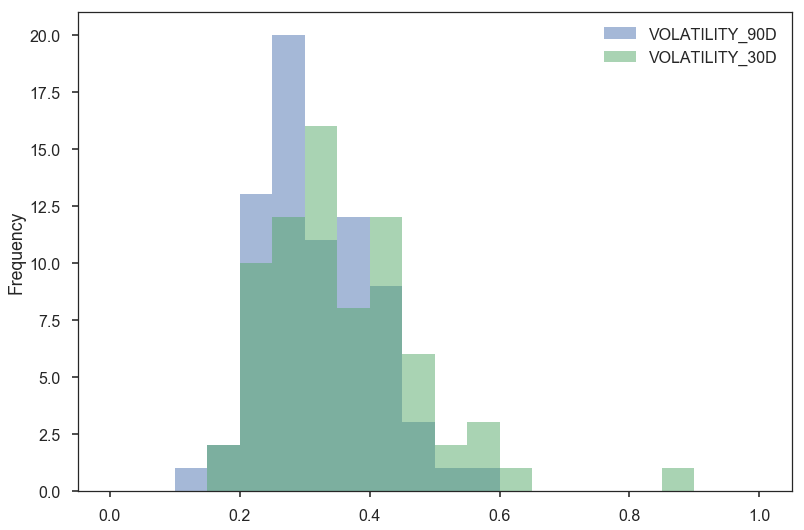

In [40]:
# Plot volatility histograms with bins from 0 to 1 with spacing of 0.05
df_volatility.plot.hist(bins=pandas.np.arange(0, 1.05, 0.05), alpha=0.5)

To retrieve the 30-day volatility time-series of a security you need to apply the `rolling` function to the volatility and define the start and end dates of this time-series using the parameter `iterationdates`. For example, you may use

```
volatility_30d_ts = bq.func.rolling(volatility_30d, iterationdates=bq.func.range('-1Y', '0D'))
```

And to retrieve the maximum volatility of this time period, you can apply the `max` function to the time-series:

```
max_volatility_30d = bq.func.max(volatility_30d_ts)
```

With that, you should be able to extend your code and include the maximum 30-day and 90-day volatilities for each member of the IBOV Index.

In [41]:
# Define maximum 30-day and 90-day volatilities
max_volatility_30d = bq.func.max(bq.func.rolling(volatility_30d, iterationdates=bq.func.range('-1Y', '0D')))
max_volatility_90d = bq.func.max(bq.func.rolling(volatility_90d, iterationdates=bq.func.range('-1Y', '0D')))

# Generate the request using the sercurity variable and data item
request =  bql.Request(
    tickers,
    {'VOLATILITY_30D': volatility_30d, 'VOLATILITY_90D': volatility_90d, 'MAX_VOLATILITY_30D': max_volatility_30d, 'MAX_VOLATILITY_90D': max_volatility_90d}
)

# Execute the request
response = bq.execute(request)

In [42]:
# Display the response in a DataFrame
df_volatility_30d = response.get('VOLATILITY_30D').df()
df_volatility_90d = response.get('VOLATILITY_90D').df()
df_max_volatility_30d = response.get('MAX_VOLATILITY_30D').df()
df_max_volatility_90d = response.get('MAX_VOLATILITY_90D').df()

In [43]:
df_volatility_30d.head()

,VOLATILITY_30D
ID,
ENBR3 BS Equity,0.249217
HGTX3 BS Equity,0.333093
RADL3 BS Equity,0.204279
BBAS3 BS Equity,0.353599
IGTA3 BS Equity,0.300241


In [44]:
df_max_volatility_30d.head()

,DATE,ORIG_IDS,ITERATION_DATE,ITERATION_ID,MAX_VOLATILITY_30D
ID,,,,,
ENBR3 BS Equity,2019-03-28,ENBR3 BS Equity,2019-03-28,None,0.444536
HGTX3 BS Equity,2020-01-27,HGTX3 BS Equity,2020-01-27,None,0.547379
RADL3 BS Equity,2019-08-10,RADL3 BS Equity,2019-08-10,None,0.487284
BBAS3 BS Equity,2019-02-24,BBAS3 BS Equity,2019-02-24,None,0.458989
IGTA3 BS Equity,2020-02-16,IGTA3 BS Equity,2020-02-16,None,0.317485


To verify if the latest volatilities of any member of the IBOV Index is above the highest volatility in the last year you can merge all data frames into one single data frame.

In [45]:
df_volatility = pandas.DataFrame([df_volatility_30d['VOLATILITY_30D'], df_max_volatility_30d['MAX_VOLATILITY_30D'], df_volatility_90d['VOLATILITY_90D'], df_max_volatility_90d['MAX_VOLATILITY_90D']]).T

In [46]:
df_volatility.head()

,VOLATILITY_30D,MAX_VOLATILITY_30D,VOLATILITY_90D,MAX_VOLATILITY_90D
ID,,,,
ENBR3 BS Equity,0.249217,0.444536,0.203368,0.343947
HGTX3 BS Equity,0.333093,0.547379,0.408540,0.429154
RADL3 BS Equity,0.204279,0.487284,0.280202,0.377190
BBAS3 BS Equity,0.353599,0.458989,0.288338,0.381795
IGTA3 BS Equity,0.300241,0.317485,0.231770,0.271267


Now you may query this data frame and verify if there is any high volatility in the IBOV Index:

In [47]:
df_volatility.query('VOLATILITY_30D >= MAX_VOLATILITY_30D | VOLATILITY_90D >= MAX_VOLATILITY_90D')

,VOLATILITY_30D,MAX_VOLATILITY_30D,VOLATILITY_90D,MAX_VOLATILITY_90D
ID,,,,
GOAU4 BS Equity,0.564286,0.564286,0.448930,0.448930
IRBR3 BS Equity,0.851317,0.880223,0.564000,0.564000
WEGE3 BS Equity,0.521383,0.521383,0.392412,0.392412
